In [1]:
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

plt.style.use("ggplot")

# Estimating Vollenweider parameters

According to Vollenweider (1975), the relationship between lake inflow and outflow concentrations for a non-volatile substance is given by

$$C_{lake} = \frac{C_{in}}{1 + \sigma \tau^n}$$

where $\tau$ is the water residence time; $\sigma$ is a parameter-specific constant representing the rate of internal cycling and removal; and $n$ is an empirically derived constant (see [here](https://nivanorge.github.io/teotil2/pages/05_retention.html) for a derivation of this, especially equation 7).

Given measured data for $C_{lake}$, $C_{in}$ and $\tau$, we would like to estimate the parameters $\sigma$ and $n$.

## 1. Define model

In [2]:
def deterministic_model(params, c_in, tau, obs=None):
    """If no observations are passed, returns the model output.
    Otherwise, returns the residuals.
    """
    v = params.valuesdict()
    model = c_in / (1 + v["sigma"] * (tau ** v["n"]))

    if obs is None:
        return model

    return model - obs

## 2. Generate test data

As a check, first generate some data that matches the equation above exactly, then add a small amount of random noise. We can then test to see if we can recover the true parameters in an ideal case.

In [3]:
# Number of data points
n_pts = 200

# Fake 'true' params
true_params = lmfit.Parameters()
true_params.add("sigma", value=3)
true_params.add("n", value=0.5)
true_params.add("err_sigma", value=0.2)

# Fake data
np.random.seed(0)
c_in = np.random.uniform(low=2, high=20, size=n_pts)
tau = np.random.uniform(low=0.1, high=3, size=n_pts)
c_lake = deterministic_model(true_params, c_in, tau)

# Add some random noise
err_sigma = true_params["err_sigma"].value
c_lake += np.random.normal(scale=err_sigma, size=n_pts)

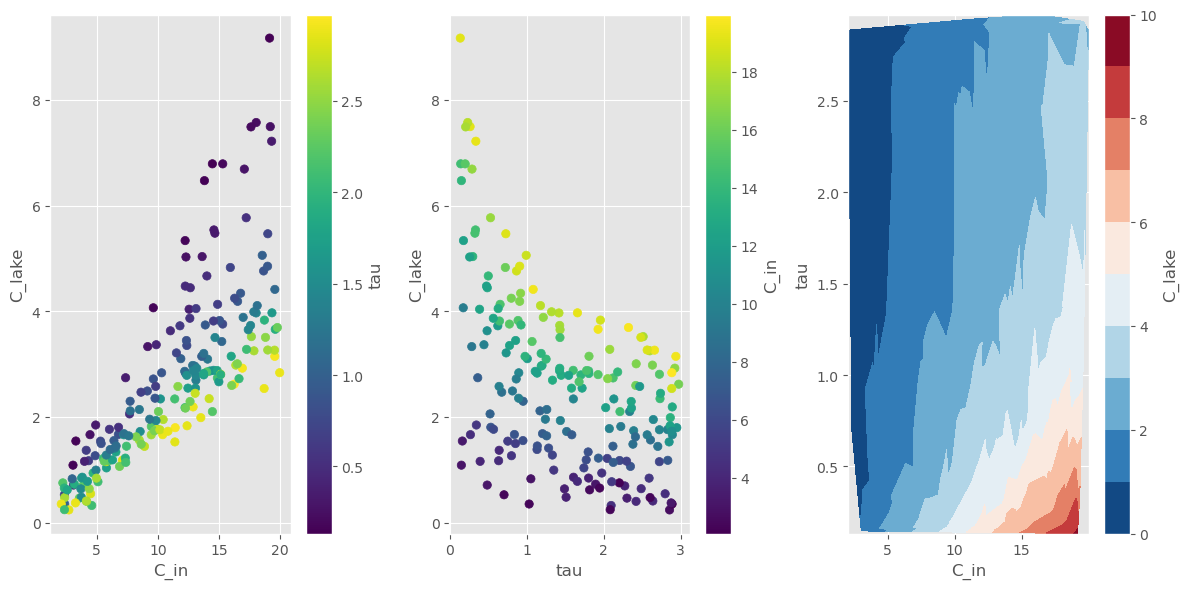

In [4]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

cbar1 = axes[0].scatter(c_in, c_lake, c=tau, marker="o")
fig.colorbar(cbar1, ax=axes[0], label="tau")
axes[0].set_xlabel("C_in")
axes[0].set_ylabel("C_lake")

cbar2 = axes[1].scatter(tau, c_lake, c=c_in, marker="o")
fig.colorbar(cbar2, ax=axes[1], label="C_in")
axes[1].set_xlabel("tau")
axes[1].set_ylabel("C_lake")

cbar3 = axes[2].tricontourf(c_in, tau, c_lake, levels=10, cmap="RdBu_r")
fig.colorbar(cbar3, ax=axes[2], label="C_lake")
axes[2].set_xlabel("C_in")
axes[2].set_ylabel("tau")

plt.tight_layout()

## 3. Optimise

In [5]:
# Define initial param guesses for optimisation
params = lmfit.Parameters()
params.add("sigma", value=1)
params.add("n", value=1)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 200
    # variables        = 2
    chi-square         = 7.76384817
    reduced chi-square = 0.03921135
    Akaike info crit   = -645.767851
    Bayesian info crit = -639.171217
[[Variables]]
    sigma:  3.01842384 +/- 0.01965696 (0.65%) (init = 3.018436)
    n:      0.50706582 +/- 0.00717679 (1.42%) (init = 0.5014908)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, n) =  0.187
[[Confidence intervals]]
          95.00%    _BEST_    95.00%
 sigma:  -0.03835   3.01842  +0.03916
 n    :  -0.01414   0.50707  +0.01418


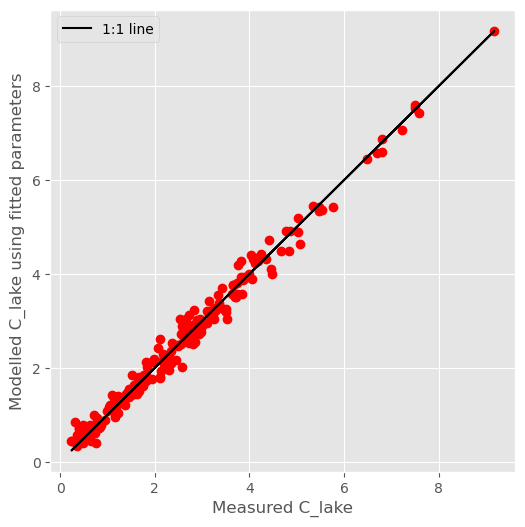

In [6]:
# Create minimiser
mi = lmfit.Minimizer(
    deterministic_model, params, fcn_args=(c_in, tau, c_lake), nan_policy="omit"
)

# First solve with Nelder-Mead (more robust than LM)
res = mi.minimize(method="nelder")

# Then solve with Levenberg-Marquardt using the Nelder-Mead solution as a starting point
res = mi.minimize(method="leastsq", params=res.params)

# Robustly estimate CI
ci = lmfit.conf_interval(
    mi,
    res,
    sigmas=[
        0.95,
    ],
)

# Calculate final result
# Residual was (model - y), so this is an easy way of getting back to 'model'
final = res.residual + c_lake

# Report
lmfit.report_fit(res)
print("[[Confidence intervals]]")
lmfit.printfuncs.report_ci(ci)

# Plot
fig = plt.figure(figsize=(6, 6))
plt.plot(c_lake, final, "ro")
plt.plot(c_lake, c_lake, "k-", label="1:1 line")
plt.legend(loc="best")
plt.xlabel("Measured C_lake")
plt.ylabel("Modelled C_lake using fitted parameters");

In the test case above, the true parameters are estimated correctly, with errors that bracket the true values and 95% CI around 1% of the estimated values.

## 4. Real data

**To do:** Compile a CSV of real data with columns for `C_in`, `C_lake` and `Tau`. Modify the code in the cell below to read this CSV and extract the columns to arrays. The code in the following cells should help to visualise the data (check for anomalies etc.) and then perform the optimisation.

In [ ]:
# Read real data
csv_path = r"path/to/data.csv"
df = pd.read_csv(csv_path)
df.dropna(how="any", inplace=True)

c_in = df["C_in_mg/l"].values
tau = df["res_time_yr"].values
c_lake = df["C_lake_mg/l"].values

In [ ]:
# Define initial param guesses for optimisation
params = lmfit.Parameters()
params.add("sigma", value=1)
params.add("n", value=1)

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

cbar1 = axes[0].scatter(c_in, c_lake, c=tau, marker="o")
fig.colorbar(cbar1, ax=axes[0], label="tau")
axes[0].set_xlabel("C_in")
axes[0].set_ylabel("C_lake")

cbar2 = axes[1].scatter(tau, c_lake, c=c_in, marker="o")
fig.colorbar(cbar2, ax=axes[1], label="C_in")
axes[1].set_xlabel("tau")
axes[1].set_ylabel("C_lake")

cbar3 = axes[2].tricontourf(c_in, tau, c_lake, levels=10, cmap="RdBu_r")
fig.colorbar(cbar3, ax=axes[2], label="C_lake")
axes[2].set_xlabel("C_in")
axes[2].set_ylabel("tau")

plt.tight_layout()

In [ ]:
# Create minimiser
mi = lmfit.Minimizer(
    deterministic_model, params, fcn_args=(c_in, tau, c_lake), nan_policy="omit"
)
res = mi.minimize(method="nelder")
res = mi.minimize(method="leastsq", params=res.params)
ci = lmfit.conf_interval(
    mi,
    res,
    sigmas=[
        0.95,
    ],
)
final = res.residual + c_lake

# Report
lmfit.report_fit(res)
print("[[Confidence intervals]]")
lmfit.printfuncs.report_ci(ci)

# Plot
fig = plt.figure(figsize=(6, 6))
plt.plot(c_lake, final, "ro")
plt.plot(c_lake, c_lake, "k-", label="1:1 line")
plt.legend(loc="best")
plt.xlabel("Measured C_lake")
plt.ylabel("Modelled C_lake using fitted parameters");